In [1]:
import sys
sys.path.append('/home/royhirsch_google_com/image_editing')

import os
import pickle
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from functools import partial
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler, DPMSolverMultistepScheduler



# Run over multiple examples

In [2]:
cat_dog_questions = [
    {
        'question': 'Is there a cat in the photo?',
        'choices': ['yes', 'no'],
        'answer': 'yes',
    },
    {
        'question': 'Is there a dog in the photo?',
        'choices': ['yes', 'no'],
        'answer': 'yes',
    },
    {
        'question': 'Is there only a single cat in the photo?',
        'choices': ['yes', 'no'],
        'answer': 'yes',
    },
    {
        'question': 'Is there only a single dog in the photo?',
        'choices': ['yes', 'no'],
        'answer': 'yes',
    },
    {
        'question': 'Is the cat is black?',
        'choices': ['yes', 'no'],
        'answer': 'yes',
    },
    {
        'question': 'Is the dog is white?',
        'choices': ['yes', 'no'],
        'answer': 'yes',
    },
    {
        'question': 'What is the color of the dog?',
        'choices': ['white', 'black'],
        'answer': 'white',
    },
    {
        'question': 'What is the color of the cat?',
        'choices': ['white', 'black'],
        'answer': 'black',
    },
    {
        'question': 'Is it a photo?',
        'choices': ['no', 'yes'],
        'answer': 'yes',
    },
    {
        'question': 'How many cats in the photo?',
        'choices': ['1', '2', '3'],
        'answer': '1',
    },
    {
        'question': 'How many dogs in the photo?',
        'choices': ['1', '2', '3'],
        'answer': '1',
    },

]

In [3]:
from tifa_utils import TifaAutoRater
tifa = TifaAutoRater()

2024-12-21 15:14:46,565 - modelscope - INFO - PyTorch version 2.4.1 Found.
2024-12-21 15:14:46,568 - modelscope - INFO - Loading ast index from /home/royhirsch_google_com/.cache/modelscope/ast_indexer
2024-12-21 15:14:46,607 - modelscope - INFO - Loading done! Current index file version is 1.15.0, with md5 dd6cd450cea4253ebfcef352dd4b0b56 and a total number of 980 components indexed


Loading mplug-large...


2024-12-21 15:14:50,176 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
2024-12-21 15:14:50,650 - modelscope - INFO - initiate model from /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en
2024-12-21 15:14:50,651 - modelscope - INFO - initiate model from location /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en.
2024-12-21 15:14:50,653 - modelscope - INFO - initialize model from /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en
/home/royhirsch_google_com/.local/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/opt/conda/envs/ml/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2102: 

load checkpoint from /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en/pytorch_model.bin
<All keys matched successfully>
Finish loading mplug-large
Using SBERT on GPU


In [ ]:
all_results = []
for path in [
    '/home/royhirsch_google_com/image_editing/cat_dog_sd2_1__0_49.pickle',
    '/home/royhirsch_google_com/image_editing/cat_dog_sd2_1__50_99.pickle',
    '/home/royhirsch_google_com/image_editing/cat_dog_sd2_1__100_149.pickle',
    '/home/royhirsch_google_com/image_editing/cat_dog_sd2_1__150_199.pickle',
]:
    with open(path, 'rb') as f:
        results = pickle.load(f)
        all_results += results['results']

inxd2score = {}
for item in all_results:
    image = item['image'].astype(np.uint8)
    image = Image.fromarray(image)
    score = tifa.get_score('/home/royhirsch_google_com/image_editing/cat_dog_images/0_image.png', cat_dog_questions)
    inxd2score[item['seed']] = score

with open('/home/royhirsch_google_com/image_editing/cat_dog_images/tifa_scores.pickle', 'wb') as f:
    pickle.dump(
        {
            'inxd2score': inxd2score,
            'questions': cat_dog_questions
         },
        f)


# Manipulate

In [3]:
all_results = []
for path in [
    '/home/royhirsch_google_com/image_editing/cat_dog_sd2_1__0_49.pickle',
    '/home/royhirsch_google_com/image_editing/cat_dog_sd2_1__50_99.pickle',
    '/home/royhirsch_google_com/image_editing/cat_dog_sd2_1__100_149.pickle',
    '/home/royhirsch_google_com/image_editing/cat_dog_sd2_1__150_199.pickle',
]:
    with open(path, 'rb') as f:
        results = pickle.load(f)
        all_results += results['results']

with open('/home/royhirsch_google_com/image_editing/cat_dog_images/tifa_scores.pickle', 'rb') as f:
    inxd2score = pickle.load(f)['inxd2score']

len(all_results)

200

(array([ 1.,  0., 29.,  0., 32.,  0., 37.,  0., 99.,  2.]),
 array([0.25  , 0.3125, 0.375 , 0.4375, 0.5   , 0.5625, 0.625 , 0.6875,
        0.75  , 0.8125, 0.875 ]),
 <BarContainer object of 10 artists>)

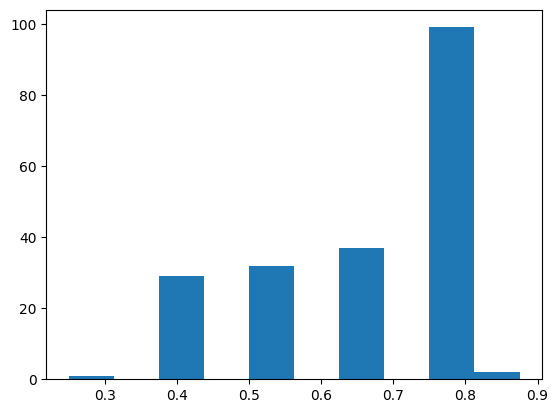

In [ ]:
plt.hist(list(inxd2score.values()))

In [16]:
device = torch.device('cuda:0')
torch_dtype = torch.float16
model_id = "stabilityai/stable-diffusion-2"
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch_dtype)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
# results['results'] is a list of dicts
# the key 'h_space' is a dict, each entry is a list of tensors

layer_name = 'down_zero'

# inxd2h_space Dict[int, List[torch.tensor]]
inxd2h_space = {}
for item in all_results:
    inxd2h_space[item['seed']] = item['h_space'][layer_name]

thresh = 0.75
pos_examples = [h_space for ind, h_space in inxd2h_space.items() if inxd2score[ind] >= thresh]
neg_examples = [h_space for ind, h_space in inxd2h_space.items() if inxd2score[ind] < thresh]
print(len(pos_examples), len(neg_examples))


def get_average_list(h_space_list):
    num_steps = len(h_space_list[0])
    mean_latents = []
    for i in range(num_steps):
        mean_latents.append(torch.stack([item[i].detach().cpu() for item in h_space_list]).mean(0))
    return mean_latents


pos_mid  = get_average_list(pos_examples)
neg_mid  = get_average_list(neg_examples)
print(len(pos_mid), pos_mid[0].shape)
print(len(neg_mid), neg_mid[0].shape)

move_vectors = [p - n for p, n in zip(pos_mid, neg_mid)]
rand_move_vectors = [torch.rand_like(item) for item in move_vectors]

101 99
50 torch.Size([2, 320, 48, 48])
50 torch.Size([2, 320, 48, 48])


In [ ]:
factors = [0, 1, 2, 4]
seed = 307

prompt = "A photo of a black cat with a white dog"

def modify_down_h_space(module, input, output, factor, step=[0]):
    sample = output[0]
    change = factor * move_vectors[step[0]].to(sample.device)
    step[0] += 1
    sample += change
    return tuple([sample] + list(output[1:]))

def modify_mid_h_space(module, input, output, factor, step=[0]):
    change = factor * move_vectors[step[0]].to(output.device)
    step[0] += 1
    return output + change

modify_h_space_func = modify_down_h_space if 'down' in layer_name else modify_mid_h_space

fig, axes = plt.subplots(1, len(factors), figsize=(len(factors) * 5, 10)) 
with torch.no_grad():
    for ind, factor in enumerate(factors):
        if 'down' in layer_name:
            num = {'zero': 0, 'one': 1, 'two': 2, 'three': 3}[layer_name.split('_')[1]]
            hook = pipe.unet.down_blocks[num].register_forward_hook(
                partial(modify_h_space_func, factor=factor, step=[0]))
        else:
            hook = pipe.unet.mid_block.register_forward_hook(
                partial(modify_h_space_func, factor=factor, step=[0]))
            
        generator = torch.Generator(device=device).manual_seed(seed)
        image = pipe(prompt, generator=generator).images[0]
        hook.remove()
        
        score = tifa.get_score(image, cat_dog_questions)
        axes[ind].imshow(image)
        axes[ind].set_title('Factor: {} Tifa: {:.3f}'.format(factor, score))
        axes[ind].axis('off')

plt.show()

# Quantiative results 

In [17]:
# generate images
factors = [0, 1, 2]
init_seed = 300
num_samples = 50
prompt = "A photo of a black cat with a white dog"

modify_h_space_func = modify_down_h_space if 'down' in layer_name else modify_mid_h_space

factor2images = {i:[] for i in factors}
with torch.no_grad():
    for seed in range(init_seed, init_seed + num_samples):
        print('###' + str(seed) + '###')
        for ind, factor in enumerate(factors):
            if 'down' in layer_name:
                num = {'zero': 0, 'one': 1, 'two': 2, 'three': 3}[layer_name.split('_')[1]]
                hook = pipe.unet.down_blocks[num].register_forward_hook(
                    partial(modify_h_space_func, factor=factor, step=[0]))
            else:
                hook = pipe.unet.mid_block.register_forward_hook(
                    partial(modify_h_space_func, factor=factor, step=[0]))
                
            generator = torch.Generator(device=device).manual_seed(seed)
            image = pipe(prompt, generator=generator).images[0]
            hook.remove()
            factor2images[factor].append(image)

with open('/home/royhirsch_google_com/image_editing/cat_dog_images/factor2eval_images.pickle', 'wb') as f:
    pickle.dump(factor2images, f)


###300###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###301###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###302###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###303###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###304###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###305###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###306###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###307###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###308###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###309###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###310###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###311###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###312###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###313###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###314###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###315###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###316###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###317###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###318###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###319###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###320###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###321###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###322###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###323###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###324###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###325###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###326###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###327###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###328###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###329###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###330###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###331###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###332###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###333###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###334###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###335###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###336###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###337###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###338###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###339###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###340###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###341###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###342###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###343###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###344###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###345###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###346###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###347###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###348###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

###349###


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# pic a score
from transformers import AutoProcessor, AutoModel

# load model
device = "cuda"
processor_name_or_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
model_pretrained_name_or_path = "yuvalkirstain/PickScore_v1"

processor = AutoProcessor.from_pretrained(processor_name_or_path)
model = AutoModel.from_pretrained(model_pretrained_name_or_path).eval().to(device)

def calc_probs(prompt, images):
    
    # preprocess
    image_inputs = processor(
        images=images,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)
    
    text_inputs = processor(
        text=prompt,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)


    with torch.no_grad():
        # embed
        image_embs = model.get_image_features(**image_inputs)
        image_embs = image_embs / torch.norm(image_embs, dim=-1, keepdim=True)
    
        text_embs = model.get_text_features(**text_inputs)
        text_embs = text_embs / torch.norm(text_embs, dim=-1, keepdim=True)
    
        # score
        scores = model.logit_scale.exp() * (text_embs @ image_embs.T)[0]
        
        # get probabilities if you have multiple images to choose from
        probs = torch.softmax(scores, dim=-1)
    
    return probs.cpu().tolist()

with open('/home/royhirsch_google_com/image_editing/cat_dog_images/factor2eval_images.pickle', 'rb') as f:
    factor2images = pickle.load(f)

factor2pick_scores = {f:[] for f in factor2images.keys()}
for f, pil_images in factor2images.items():
    # pil_images = [Image.fromarray(image) for image in images]
    factor2pick_scores[f] = np.asarray(calc_probs(prompt, pil_images))

In [55]:
base_scores = factor2pick_scores[0]
cand_scores = factor2pick_scores[1]
hits = []
for b, c in zip(base_scores, cand_scores):
    hits.append(c > b)
print(np.mean(hits))

0.54


In [36]:
from tifa_utils import TifaAutoRater
tifa = TifaAutoRater()

2024-12-21 16:12:05,216 - modelscope - INFO - PyTorch version 2.4.1 Found.
2024-12-21 16:12:05,218 - modelscope - INFO - Loading ast index from /home/royhirsch_google_com/.cache/modelscope/ast_indexer
2024-12-21 16:12:05,380 - modelscope - INFO - Loading done! Current index file version is 1.15.0, with md5 dd6cd450cea4253ebfcef352dd4b0b56 and a total number of 980 components indexed
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading mplug-large...


2024-12-21 16:12:12,759 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
2024-12-21 16:12:13,238 - modelscope - INFO - initiate model from /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en
2024-12-21 16:12:13,239 - modelscope - INFO - initiate model from location /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en.
2024-12-21 16:12:13,241 - modelscope - INFO - initialize model from /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en
/home/royhirsch_google_com/.local/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/opt/conda/envs/ml/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2102: 

load checkpoint from /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en/pytorch_model.bin
<All keys matched successfully>
Finish loading mplug-large
Using SBERT on GPU


In [37]:
factor2tifa_scores = {f:[] for f in factor2images.keys()}
for f, pil_images in factor2images.items():
    for image in pil_images:
        factor2tifa_scores[f].append(tifa.get_score(image, cat_dog_questions))
for k, v in factor2tifa_scores.items():
    factor2tifa_scores[k] = np.asarray(v)

  0%|          | 0/11 [00:00<?, ?it/s]/opt/conda/envs/ml/lib/python3.8/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/envs/ml/lib/python3.8/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 11/11 [00:02<00:00,  5.37it/s]


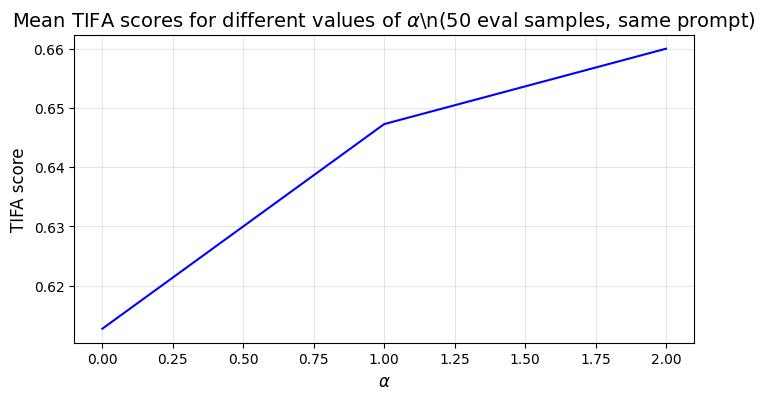

In [51]:
x = list(factor2tifa_scores.keys())
means = np.asarray([np.mean(v) for v in factor2tifa_scores.values()])
stds = np.asarray([np.std(v) for v in factor2tifa_scores.values()])
plt.figure(figsize=(8, 4))
plt.plot(x, means, label='Mean', color='blue')

# plt.fill_between(x, means - stds, means + stds, color='blue', alpha=0.2, label='Mean ± Std Dev')

# Add labels and legend
plt.title(r"Mean TIFA scores for different values of $\alpha$\n(50 eval samples, same prompt)", fontsize=14)
plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel("TIFA score", fontsize=12)
# plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()


In [56]:
means

array([0.61272727, 0.64727273, 0.66      ])